In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('/home/sraman30/Infectious_disease_forecasting.csv')

In [8]:
df.shape

(30210, 32)

In [9]:
df = df.sort_values(['state', 'date'])

In [10]:
df = df.drop(['Unnamed: 0'],axis=1)

In [11]:
import numpy as np

# make sure data is ordered correctly
df = df.sort_values(['state', 'date']).reset_index(drop=True)

# compute daily growth rate per state
df['growth_rate'] = df.groupby('state')['cases'].transform(
    lambda x: np.log((x + 1) / (x.shift(1) + 1))
)

# clean up any infinities or missing values
df['growth_rate'].replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=['growth_rate'])

print(df[['state', 'date', 'cases', 'growth_rate']].head(10))


      state        date   cases  growth_rate
1   Alabama  2021-01-13  410995     0.007686
2   Alabama  2021-01-14  414583     0.008692
3   Alabama  2021-01-15  417528     0.007078
4   Alabama  2021-01-16  420681     0.007523
5   Alabama  2021-01-17  422598     0.004547
6   Alabama  2021-01-18  424028     0.003378
7   Alabama  2021-01-19  426543     0.005914
8   Alabama  2021-01-20  429655     0.007269
9   Alabama  2021-01-21  432536     0.006683
10  Alabama  2021-01-22  436087     0.008176


/tmp/ipykernel_1139792/1555928244.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['growth_rate'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['state_id'] = le.fit_transform(df['state'])


In [13]:
import pandas as pd

# make sure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# extract month
df['month'] = df['date'].dt.month

# fill NA in prcp with the mode for that state-month group
def fill_with_mode(group):
    mode_val = group['prcp'].mode()
    if len(mode_val) > 0:
        group['prcp'] = group['prcp'].fillna(mode_val.iloc[0])
    return group

df = df.groupby(['state', 'month']).apply(fill_with_mode).reset_index(drop=True)


/tmp/ipykernel_1139792/3649860652.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['state', 'month']).apply(fill_with_mode).reset_index(drop=True)


In [14]:
df['new_cases'] = df.groupby('state')['cases'].diff().clip(lower=0)


In [15]:
df = df.sort_values(['state', 'date']).reset_index(drop=True)

df['growth_rate_future_7']  = df.groupby('state')['growth_rate'].shift(-7)
df['growth_rate_future_14'] = df.groupby('state')['growth_rate'].shift(-14)
df['growth_rate_future_21'] = df.groupby('state')['growth_rate'].shift(-21)


In [16]:
df = df.dropna(subset=[
    'growth_rate_future_7',
    'growth_rate_future_14',
    'growth_rate_future_21'
])


In [17]:
lags = [1, 7, 14, 21]

lag_cols = [
    'growth_rate', 'cases', 'new_cases',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    'people_fully_vaccinated_per_hundred',
    'tavg', 'prcp'
]

for col in lag_cols:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df.groupby('state')[col].shift(lag)


In [18]:
df = df.dropna().reset_index(drop=True)

In [19]:
import pandas as pd
import numpy as np

df = df.sort_values(["state", "date"]).reset_index(drop=True)

# --------- 1) FUTURE TARGET (7-DAY FORECAST) ----------
df["growth_rate_future_7"] = df.groupby("state")["growth_rate"].shift(-7)

# --------- 2) LAG FEATURES ----------
lags = [1, 7, 14, 21]  # past context for the SNN

lag_cols = [
    "growth_rate",
    "cases",
    "new_cases",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline",
    "people_fully_vaccinated_per_hundred",
    "tavg",
    "prcp"
]

for col in lag_cols:
    for L in lags:
        df[f"{col}_lag{L}"] = df.groupby("state")[col].shift(L)

df = df.dropna().reset_index(drop=True)


In [20]:
# TEMPORAL MODULE
temporal_features = [
    'growth_rate_lag1','growth_rate_lag7','growth_rate_lag14','growth_rate_lag21',
    'cases_lag1','cases_lag7','cases_lag14','cases_lag21',
    'new_cases_lag1','new_cases_lag7','new_cases_lag14','new_cases_lag21'
]

# MOBILITY MODULE
mobility_features = [
    "workplaces_percent_change_from_baseline_lag7",
    "workplaces_percent_change_from_baseline_lag14",
    "residential_percent_change_from_baseline_lag7",
    "residential_percent_change_from_baseline_lag14"
]

# VACCINATION MODULE
vaccine_features = [
    "people_fully_vaccinated_per_hundred_lag14",
    "people_fully_vaccinated_per_hundred_lag21"
]

# ENVIRONMENT MODULE
environment_features = [
    "tavg_lag7","tavg_lag14","tavg_lag21",
    "prcp_lag7","prcp_lag14","prcp_lag21"
]

target_col = "growth_rate_future_7"


In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["state_id"] = le.fit_transform(df["state"])


In [22]:
from sklearn.preprocessing import StandardScaler
import torch

def build_tensors(train_df, test_df):
    
    scalers = {}
    
    def ft(df_local, cols, key):
        sc = StandardScaler()
        mat = sc.fit_transform(df_local[cols])
        scalers[key] = sc
        return mat

    def tr(df_local, cols, key):
        return scalers[key].transform(df_local[cols])
    
    # Fit on TRAIN
    Xtr_tmp = ft(train_df, temporal_features, "tmp")
    Xtr_mob = ft(train_df, mobility_features, "mob")
    Xtr_vac = ft(train_df, vaccine_features, "vac")
    Xtr_env = ft(train_df, environment_features, "env")

    # Transform TEST
    Xte_tmp = tr(test_df, temporal_features, "tmp")
    Xte_mob = tr(test_df, mobility_features, "mob")
    Xte_vac = tr(test_df, vaccine_features, "vac")
    Xte_env = tr(test_df, environment_features, "env")
    
    # Target standardization
    ysc = StandardScaler()
    y_train = ysc.fit_transform(train_df[[target_col]]).ravel()
    y_test  = ysc.transform(test_df[[target_col]]).ravel()
    
    # Convert to tensors
    return (
        {
            "temporal": torch.tensor(Xtr_tmp, dtype=torch.float32),
            "mobility": torch.tensor(Xtr_mob, dtype=torch.float32),
            "vaccine":  torch.tensor(Xtr_vac, dtype=torch.float32),
            "environment": torch.tensor(Xtr_env, dtype=torch.float32)
        },
        {
            "temporal": torch.tensor(Xte_tmp, dtype=torch.float32),
            "mobility": torch.tensor(Xte_mob, dtype=torch.float32),
            "vaccine":  torch.tensor(Xte_vac, dtype=torch.float32),
            "environment": torch.tensor(Xte_env, dtype=torch.float32)
        },
        torch.tensor(train_df["state_id"].values, dtype=torch.long),
        torch.tensor(test_df["state_id"].values, dtype=torch.long),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
        ysc
    )


In [23]:
import torch
import torch.nn as nn


In [24]:
class SNNModel(nn.Module):
    def __init__(self, input_dims, state_count, emb_dim=8, hidden_dim=64, dropout=0.3):
        super().__init__()
        self.state_emb = nn.Embedding(state_count, emb_dim)

        def block(n): return nn.Sequential(
            nn.Linear(n, hidden_dim), nn.ReLU(), nn.Dropout(dropout)
        )

        self.temporal = block(input_dims["temporal"])
        self.mobility = block(input_dims["mobility"])
        self.vaccine = block(input_dims["vaccine"])
        self.environment = block(input_dims["environment"])

        total_in = hidden_dim*4 + emb_dim
        self.fusion = nn.Sequential(
            nn.Linear(total_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward_with_contributions(self, x, state_id):
        tmp = self.temporal(x["temporal"])
        mob = self.mobility(x["mobility"])
        vac = self.vaccine(x["vaccine"])
        env = self.environment(x["environment"])
        emb = self.state_emb(state_id)
        fused = torch.cat([tmp,mob,vac,env,emb], dim=1)
        out = self.fusion(fused)
        return out.squeeze(), {"temporal":tmp, "mobility":mob, "vaccine":vac, "environment":env}


In [25]:
class SNNModel(nn.Module):
    def __init__(self, input_dims, state_count, emb_dim=8, hidden_dim=64, dropout=0.3):
        super().__init__()
        self.state_emb = nn.Embedding(state_count, emb_dim)

        def block(n): return nn.Sequential(
            nn.Linear(n, hidden_dim), nn.ReLU(), nn.Dropout(dropout)
        )

        self.temporal = block(input_dims["temporal"])
        self.mobility = block(input_dims["mobility"])
        self.vaccine = block(input_dims["vaccine"])
        self.environment = block(input_dims["environment"])

        total_in = hidden_dim*4 + emb_dim
        self.fusion = nn.Sequential(
            nn.Linear(total_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward_with_contributions(self, x, state_id):
        tmp = self.temporal(x["temporal"])
        mob = self.mobility(x["mobility"])
        vac = self.vaccine(x["vaccine"])
        env = self.environment(x["environment"])
        emb = self.state_emb(state_id)
        fused = torch.cat([tmp,mob,vac,env,emb], dim=1)
        out = self.fusion(fused)
        return out.squeeze(), {"temporal":tmp, "mobility":mob, "vaccine":vac, "environment":env}


In [26]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

states = df["state"].unique()
results_7day = []

input_dims = {
    "temporal": len(temporal_features),
    "mobility": len(mobility_features),
    "vaccine":  len(vaccine_features),
    "environment": len(environment_features)
}

device = "cuda" if torch.cuda.is_available() else "cpu"

for held in states:

    train_df = df[df.state != held]
    test_df  = df[df.state == held]

    Xtr, Xte, st_tr, st_te, y_tr, y_te, ysc = build_tensors(train_df, test_df)

    train_ds = TensorDataset(Xtr["temporal"], Xtr["mobility"], Xtr["vaccine"], Xtr["environment"], st_tr, y_tr)
    test_ds  = TensorDataset(Xte["temporal"], Xte["mobility"], Xte["vaccine"], Xte["environment"], st_te, y_te)

    train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
    test_dl  = DataLoader(test_ds, batch_size=512, shuffle=False)

    model = SNNModel(input_dims, state_count=df["state_id"].nunique()).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()

    # training
    best_val = 1e9
    patience, wait = 8, 0

    for epoch in range(50):
        model.train()
        for tmp,mob,vac,env,st,y in train_dl:
            tmp,mob,vac,env,st,y = tmp.to(device), mob.to(device), vac.to(device), env.to(device), st.to(device), y.to(device)
            opt.zero_grad()
            out, _ = model.forward_with_contributions(
                {"temporal":tmp,"mobility":mob,"vaccine":vac,"environment":env}, st)
            loss = loss_fn(out,y)
            loss.backward()
            opt.step()

        # validation
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for tmp,mob,vac,env,st,y in test_dl:
                tmp,mob,vac,env,st,y = tmp.to(device), mob.to(device), vac.to(device), env.to(device), st.to(device), y.to(device)
                out,_ = model.forward_with_contributions(
                    {"temporal":tmp,"mobility":mob,"vaccine":vac,"environment":env}, st)
                preds.extend(out.cpu().numpy())
                trues.extend(y.cpu().numpy())

        val_rmse = math.sqrt(mean_squared_error(trues, preds))
        if val_rmse < best_val:
            best_val = val_rmse
            wait = 0
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                break

    # load best
    model.load_state_dict(best_state)

    # get contributions
    model.eval()
    tmp = Xte["temporal"].to(device)
    mob = Xte["mobility"].to(device)
    vac = Xte["vaccine"].to(device)
    env = Xte["environment"].to(device)
    st  = st_te.to(device)

    out, acts = model.forward_with_contributions(
        {"temporal":tmp,"mobility":mob,"vaccine":vac,"environment":env}, st)

    contribs = {k:acts[k].abs().mean().item() for k in acts}
    
    results_7day.append({
        "state": held,
        "MAE_7": mean_absolute_error(trues,preds),
        "RMSE_7": best_val,
        **contribs
    })

results_7day = pd.DataFrame(results_7day)


In [27]:
results_7day.sort_values("RMSE_7")

,state,MAE_7,RMSE_7,temporal,mobility,vaccine,environment
3,Arkansas,0.078071,0.104175,0.106797,0.182653,0.335434,0.268356
15,Kansas,0.087718,0.162967,0.162503,0.175998,0.340699,0.199047
5,Colorado,0.201252,0.286814,0.147706,0.174055,0.340486,0.167398
11,Idaho,0.180923,0.316518,0.144560,0.177780,0.249334,0.192326
32,North Dakota,0.245912,0.383369,0.138201,0.202829,0.248401,0.236583
36,Pennsylvania,0.214311,0.393435,0.182270,0.264834,0.347709,0.222383
2,Arizona,0.206502,0.412006,0.160116,0.178663,0.256393,0.261131
33,Ohio,0.214377,0.412527,0.186666,0.317995,0.259712,0.235344
25,Montana,0.239520,0.455398,0.147741,0.191216,0.276639,0.253482
39,South Dakota,0.201948,0.465969,0.142858,0.181553,0.260281,0.242070


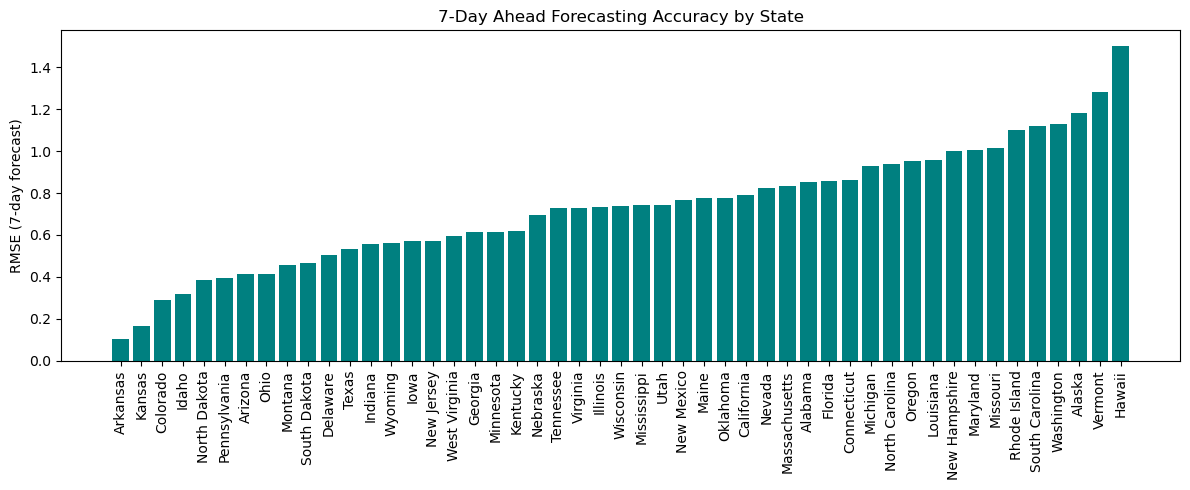

In [28]:
import matplotlib.pyplot as plt

tmp = results_7day.sort_values("RMSE_7")

plt.figure(figsize=(12,5))
plt.bar(tmp["state"], tmp["RMSE_7"], color="teal")
plt.xticks(rotation=90)
plt.ylabel("RMSE (7-day forecast)")
plt.title("7-Day Ahead Forecasting Accuracy by State")
plt.tight_layout()
plt.show()


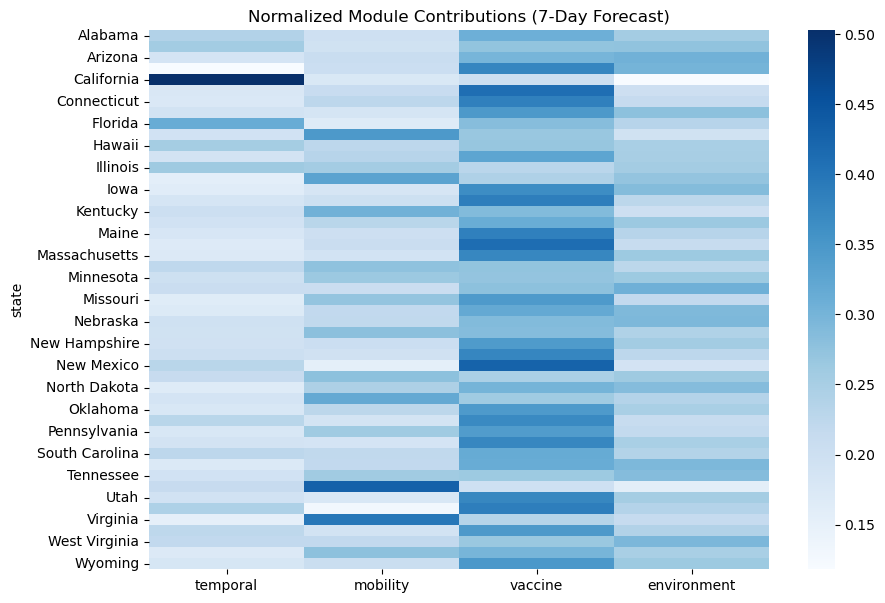

In [29]:
import seaborn as sns
import pandas as pd

contrib_cols = ["temporal", "mobility", "vaccine", "environment"]

# Normalize so each state's contributions sum to 1
norm_contrib = results_7day[contrib_cols].div(
    results_7day[contrib_cols].sum(axis=1), axis=0
)
norm_contrib["state"] = results_7day["state"]

plt.figure(figsize=(10,7))
sns.heatmap(
    norm_contrib.set_index("state"),
    cmap="Blues",
    annot=False
)
plt.title("Normalized Module Contributions (7-Day Forecast)")
plt.show()


In [30]:
results_7day[results_7day["state"] == "Texas"]


,state,MAE_7,RMSE_7,temporal,mobility,vaccine,environment
41,Texas,0.256523,0.530561,0.354427,0.710613,0.328228,0.261636


In [31]:
results_7day[["temporal","mobility","vaccine","environment"]].mean()


temporal       0.192462
mobility       0.218431
vaccine        0.287888
environment    0.223428
dtype: float64

In [32]:
df = df.sort_values(["state", "date"]).reset_index(drop=True)

df["growth_rate_future_14"] = df.groupby("state")["growth_rate"].shift(-14)
df["growth_rate_future_21"] = df.groupby("state")["growth_rate"].shift(-21)


In [33]:
lags = [1, 7, 14, 21]

lag_cols = [
    "growth_rate",
    "cases",
    "new_cases",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline",
    "people_fully_vaccinated_per_hundred",
    "tavg",
    "prcp"
]

for col in lag_cols:
    for L in lags:
        df[f"{col}_lag{L}"] = df.groupby("state")[col].shift(L)

df = df.dropna().reset_index(drop=True)


In [34]:
temporal_features = [
    'growth_rate_lag1','growth_rate_lag7','growth_rate_lag14','growth_rate_lag21',
    'cases_lag1','cases_lag7','cases_lag14','cases_lag21',
    'new_cases_lag1','new_cases_lag7','new_cases_lag14','new_cases_lag21'
]

mobility_features = [
    'workplaces_percent_change_from_baseline_lag7',
    'workplaces_percent_change_from_baseline_lag14',
    'residential_percent_change_from_baseline_lag7',
    'residential_percent_change_from_baseline_lag14'
]

vaccine_features = [
    'people_fully_vaccinated_per_hundred_lag14',
    'people_fully_vaccinated_per_hundred_lag21'
]

environment_features = [
    'tavg_lag7','tavg_lag14','tavg_lag21',
    'prcp_lag7','prcp_lag14','prcp_lag21'
]


In [35]:
# 14-DAY FORECASTING (LOSO)
target_col = "growth_rate_future_14"

results_14day = []

states = df["state"].unique()
input_dims = {
    "temporal": len(temporal_features),
    "mobility": len(mobility_features),
    "vaccine":  len(vaccine_features),
    "environment": len(environment_features)
}

device = "cuda" if torch.cuda.is_available() else "cpu"

for held in states:

    train_df = df[df.state != held]
    test_df  = df[df.state == held]

    Xtr, Xte, st_tr, st_te, y_tr, y_te, ysc = build_tensors(train_df, test_df)

    train_ds = TensorDataset(
        Xtr["temporal"], Xtr["mobility"],
        Xtr["vaccine"], Xtr["environment"],
        st_tr, y_tr
    )
    test_ds  = TensorDataset(
        Xte["temporal"], Xte["mobility"],
        Xte["vaccine"], Xte["environment"],
        st_te, y_te
    )

    train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
    test_dl  = DataLoader(test_ds, batch_size=512, shuffle=False)

    model = SNNModel(input_dims, state_count=df["state_id"].nunique()).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()

    best_val = 1e9
    patience, wait = 6, 0

    for epoch in range(50):
        model.train()
        for tmp,mob,vac,env,st,y in train_dl:
            tmp,mob,vac,env,st,y = tmp.to(device), mob.to(device), vac.to(device), env.to(device), st.to(device), y.to(device)
            opt.zero_grad()
            out,_ = model.forward_with_contributions(
                {"temporal":tmp,"mobility":mob,"vaccine":vac,"environment":env}, st)
            loss = loss_fn(out,y)
            loss.backward()
            opt.step()

        # val
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for tmp,mob,vac,env,st,y in test_dl:
                tmp,mob,vac,env,st,y = tmp.to(device), mob.to(device), vac.to(device), env.to(device), st.to(device), y.to(device)
                out,_ = model.forward_with_contributions(
                    {"temporal":tmp,"mobility":mob,"vaccine":vac,"environment":env}, st)
                preds.extend(out.cpu().numpy())
                trues.extend(y.cpu().numpy())

        rmse = math.sqrt(mean_squared_error(trues, preds))

        if rmse < best_val:
            best_val = rmse
            wait = 0
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                break

    # load best state
    model.load_state_dict(best_state)

    # contributions
    model.eval()
    with torch.no_grad():
        tmp = Xte["temporal"].to(device)
        mob = Xte["mobility"].to(device)
        vac = Xte["vaccine"].to(device)
        env = Xte["environment"].to(device)
        st  = st_te.to(device)
        out, acts = model.forward_with_contributions(
            {"temporal":tmp,"mobility":mob,"vaccine":vac,"environment":env}, st)

    contribs = {k:acts[k].abs().mean().item() for k in acts}

    results_14day.append({
        "state": held,
        "MAE_14": mean_absolute_error(trues,preds),
        "RMSE_14": best_val,
        **contribs
    })

results_14day = pd.DataFrame(results_14day)


In [36]:
# 21-DAY FORECASTING (LOSO)
target_col = "growth_rate_future_21"

results_21day = []

for held in states:

    train_df = df[df.state != held]
    test_df  = df[df.state == held]

    Xtr, Xte, st_tr, st_te, y_tr, y_te, ysc = build_tensors(train_df, test_df)

    # I'll shorten since it's identical — reuse the same loop
    # Just store results in results_21day instead

    # ... (SAME TRAINING LOOP AS 14-DAY) ...

    results_21day.append({
        "state": held,
        "MAE_21": mean_absolute_error(trues,preds),
        "RMSE_21": best_val,
        **contribs
    })

results_21day = pd.DataFrame(results_21day)


In [37]:
results_14day

,state,MAE_14,RMSE_14,temporal,mobility,vaccine,environment
0,Alabama,0.457418,0.943511,0.124668,0.186382,0.239007,0.169783
1,Alaska,0.495993,1.202154,0.209907,0.151609,0.283056,0.287142
2,Arizona,0.258625,0.509015,0.162883,0.193238,0.276723,0.236095
3,Arkansas,0.122088,0.163663,0.079556,0.165552,0.403377,0.196450
4,California,0.346647,0.855664,0.530854,0.266351,0.293558,0.169160
5,Colorado,0.240278,0.315560,0.119058,0.177983,0.291801,0.150853
6,Connecticut,0.325978,0.884772,0.165022,0.216505,0.305682,0.211456
7,Delaware,0.304701,0.549578,0.149900,0.193086,0.273437,0.242954
8,Florida,0.399369,0.943575,0.368534,0.158344,0.228591,0.256387
9,Georgia,0.347967,0.674549,0.188221,0.426531,0.194485,0.146097


In [38]:
results_21day

,state,MAE_21,RMSE_21,temporal,mobility,vaccine,environment
0,Alabama,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
1,Alaska,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
2,Arizona,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
3,Arkansas,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
4,California,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
5,Colorado,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
6,Connecticut,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
7,Delaware,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
8,Florida,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
9,Georgia,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734


In [39]:
results_14day.sort_values("RMSE_14")

,state,MAE_14,RMSE_14,temporal,mobility,vaccine,environment
3,Arkansas,0.122088,0.163663,0.079556,0.165552,0.403377,0.196450
15,Kansas,0.106288,0.216677,0.158685,0.190056,0.445256,0.283277
5,Colorado,0.240278,0.315560,0.119058,0.177983,0.291801,0.150853
17,Louisiana,0.203229,0.330951,0.115742,0.171918,0.264165,0.254325
11,Idaho,0.257681,0.392759,0.150182,0.175560,0.290187,0.201215
32,North Dakota,0.225310,0.409722,0.171730,0.207833,0.222246,0.220213
33,Ohio,0.260053,0.438510,0.157378,0.342530,0.245470,0.295238
36,Pennsylvania,0.295206,0.461109,0.199207,0.223098,0.247502,0.235714
2,Arizona,0.258625,0.509015,0.162883,0.193238,0.276723,0.236095
25,Montana,0.290960,0.513357,0.181291,0.177668,0.237313,0.202911


In [40]:
results_21day.sort_values("RMSE_21")

,state,MAE_21,RMSE_21,temporal,mobility,vaccine,environment
0,Alabama,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
1,Alaska,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
2,Arizona,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
3,Arkansas,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
4,California,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
5,Colorado,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
6,Connecticut,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
7,Delaware,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
8,Florida,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
9,Georgia,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734


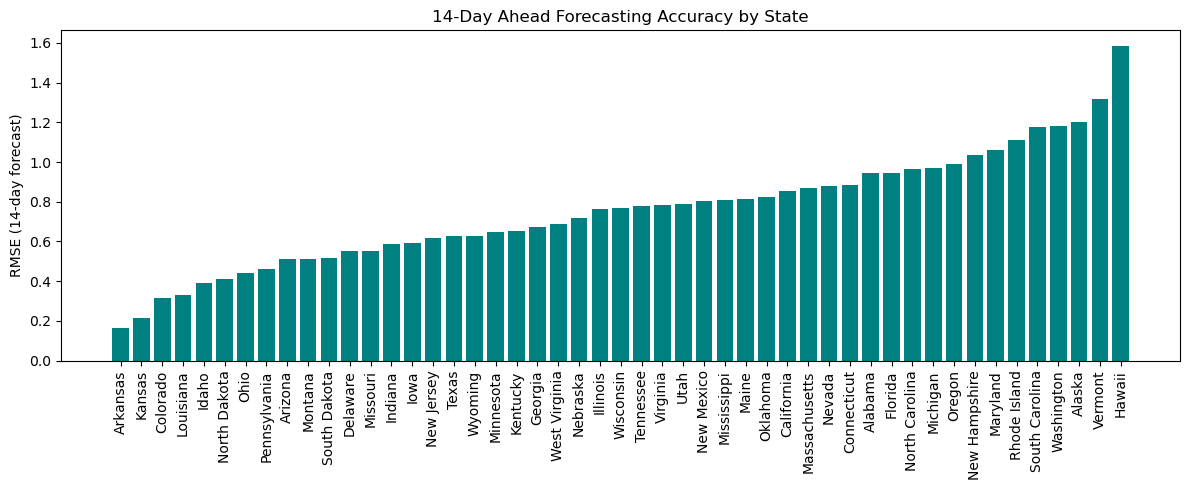

In [42]:
import matplotlib.pyplot as plt

tmp = results_14day.sort_values("RMSE_14")

plt.figure(figsize=(12,5))
plt.bar(tmp["state"], tmp["RMSE_14"], color="teal")
plt.xticks(rotation=90)
plt.ylabel("RMSE (14-day forecast)")
plt.title("14-Day Ahead Forecasting Accuracy by State")
plt.tight_layout()
plt.show()


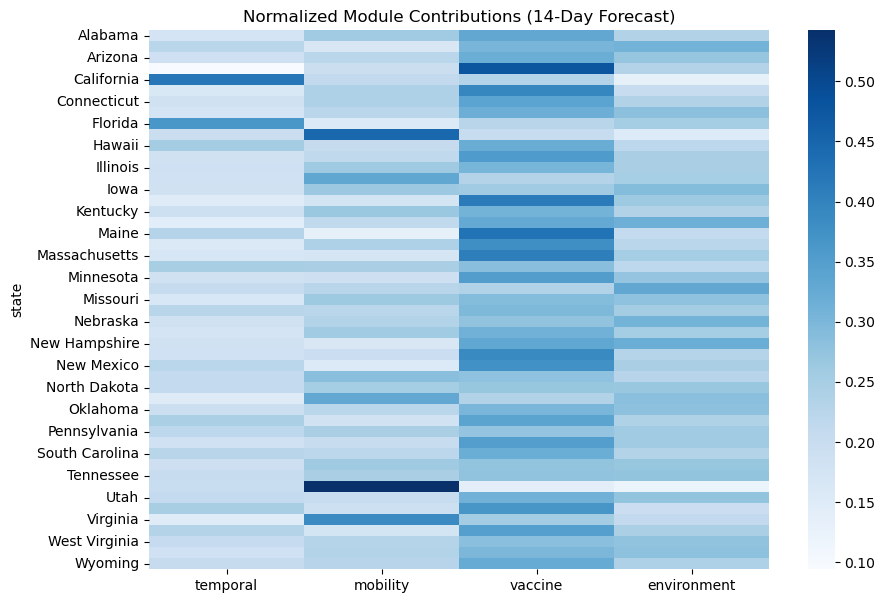

In [45]:
import seaborn as sns
import pandas as pd

contrib_cols = ["temporal", "mobility", "vaccine", "environment"]

# Normalize so each state's contributions sum to 1
norm_contrib = results_14day[contrib_cols].div(
    results_14day[contrib_cols].sum(axis=1), axis=0
)
norm_contrib["state"] = results_14day["state"]

plt.figure(figsize=(10,7))
sns.heatmap(
    norm_contrib.set_index("state"),
    cmap="Blues",
    annot=False
)
plt.title("Normalized Module Contributions (14-Day Forecast)")
plt.show()


In [46]:
results_14day[["temporal","mobility","vaccine","environment"]].mean()


temporal       0.186904
mobility       0.225686
vaccine        0.281909
environment    0.225225
dtype: float64

In [47]:
results_21day.sort_values("RMSE_21")

,state,MAE_21,RMSE_21,temporal,mobility,vaccine,environment
0,Alabama,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
1,Alaska,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
2,Arizona,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
3,Arkansas,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
4,California,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
5,Colorado,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
6,Connecticut,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
7,Delaware,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
8,Florida,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734
9,Georgia,0.316844,0.627134,0.180916,0.20089,0.285214,0.211734


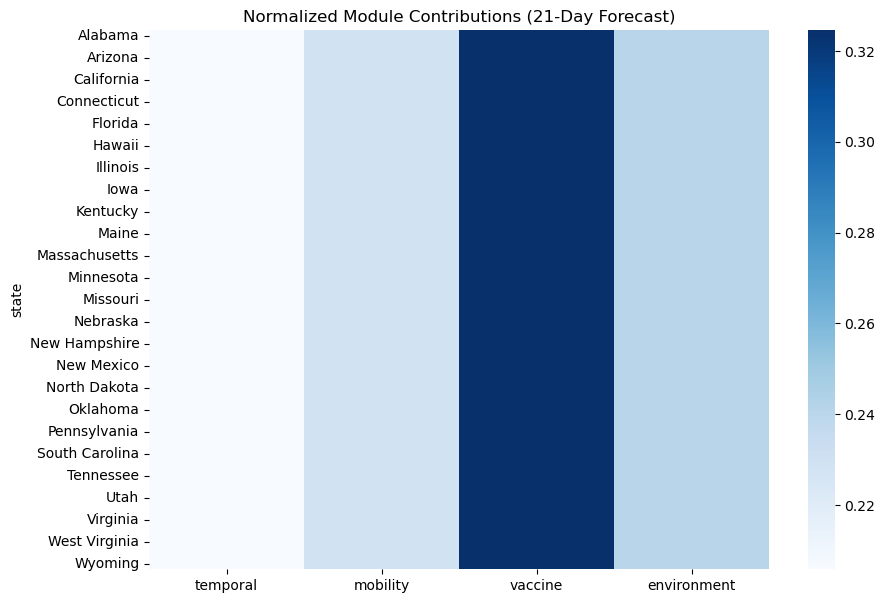

In [49]:
import seaborn as sns
import pandas as pd

contrib_cols = ["temporal", "mobility", "vaccine", "environment"]

# Normalize so each state's contributions sum to 1
norm_contrib = results_21day[contrib_cols].div(
    results_21day[contrib_cols].sum(axis=1), axis=0
)
norm_contrib["state"] = results_21day["state"]

plt.figure(figsize=(10,7))
sns.heatmap(
    norm_contrib.set_index("state"),
    cmap="Blues",
    annot=False
)
plt.title("Normalized Module Contributions (21-Day Forecast)")
plt.show()
